In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, ConfusionMatrixDisplay
)

In [2]:
#Load dataset
df = pd.read_csv("hospitalReadmissions.csv")
df

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,none,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,none,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,none,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,[80-90),14,77,1,30,0,0,0,none,Circulatory,Other,Circulatory,no,normal,no,no,yes
24996,[80-90),2,66,0,24,0,0,0,none,Digestive,Injury,Other,no,high,yes,yes,yes
24997,[70-80),5,12,0,6,0,1,0,none,Other,Other,Other,normal,no,no,no,yes
24998,[70-80),2,61,3,15,0,0,0,Family/GeneralPractice,Respiratory,Diabetes,Other,no,no,yes,yes,no


In [18]:
df["readmitted"] = df["readmitted"].map({"no": 0, "yes": 1})


In [3]:
#Preprocessing
df.fillna("Unknown", inplace=True)

label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop("readmitted", axis=1)
y = df["readmitted"]

In [4]:
#Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [8]:
#Logistic Regression Model
log_model = LogisticRegression(C=1.0, max_iter=1000, solver='lbfgs')
log_model.fit(X_train, y_train)

#Predictions
log_pred = log_model.predict(X_test)
log_prob = log_model.predict_proba(X_test)[:, 1]

#Accuracy & Report
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, log_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, log_pred))

#Save Model
import joblib
joblib.dump(log_model, "logistic_readmission_model.pkl")
print("Model saved as 'logistic_readmission_model.pkl'")

Logistic Regression Accuracy: 0.6112

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.79      0.68      2658
           1       0.63      0.40      0.49      2342

    accuracy                           0.61      5000
   macro avg       0.62      0.60      0.59      5000
weighted avg       0.62      0.61      0.59      5000

Model saved as 'logistic_readmission_model.pkl'


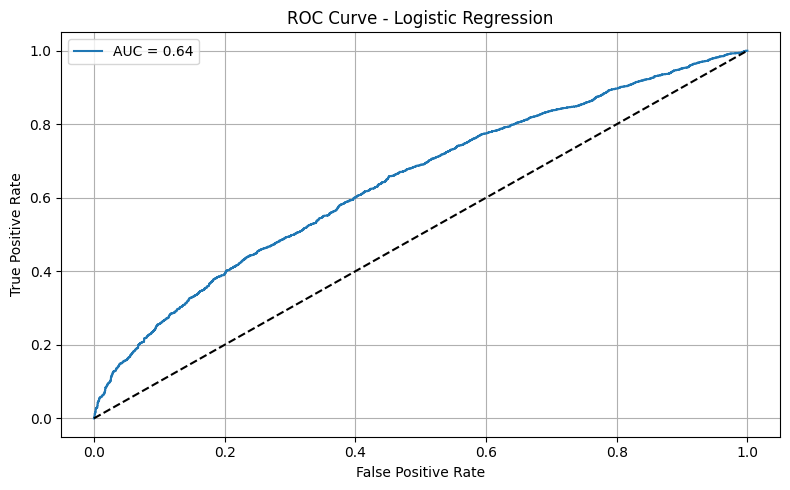

In [9]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test, log_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

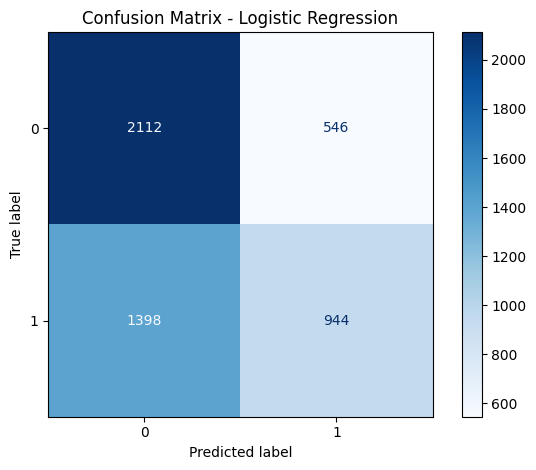

In [10]:
#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

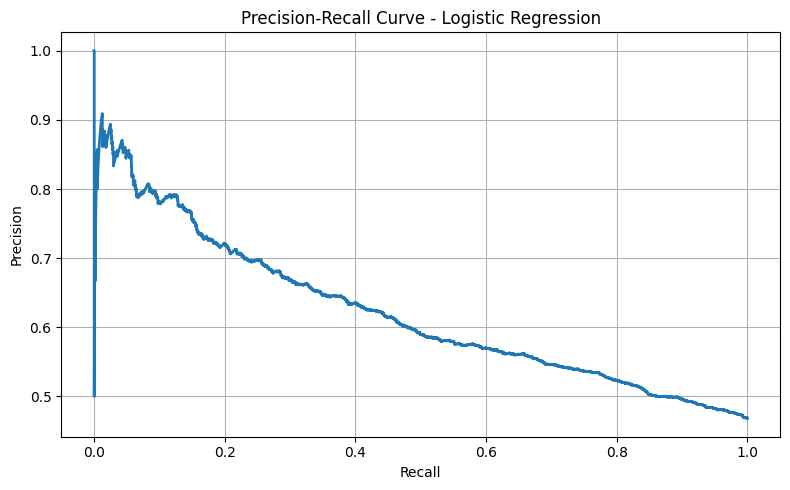

In [11]:
#Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, log_prob)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, lw=2)
plt.title("Precision-Recall Curve - Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
plt.show()

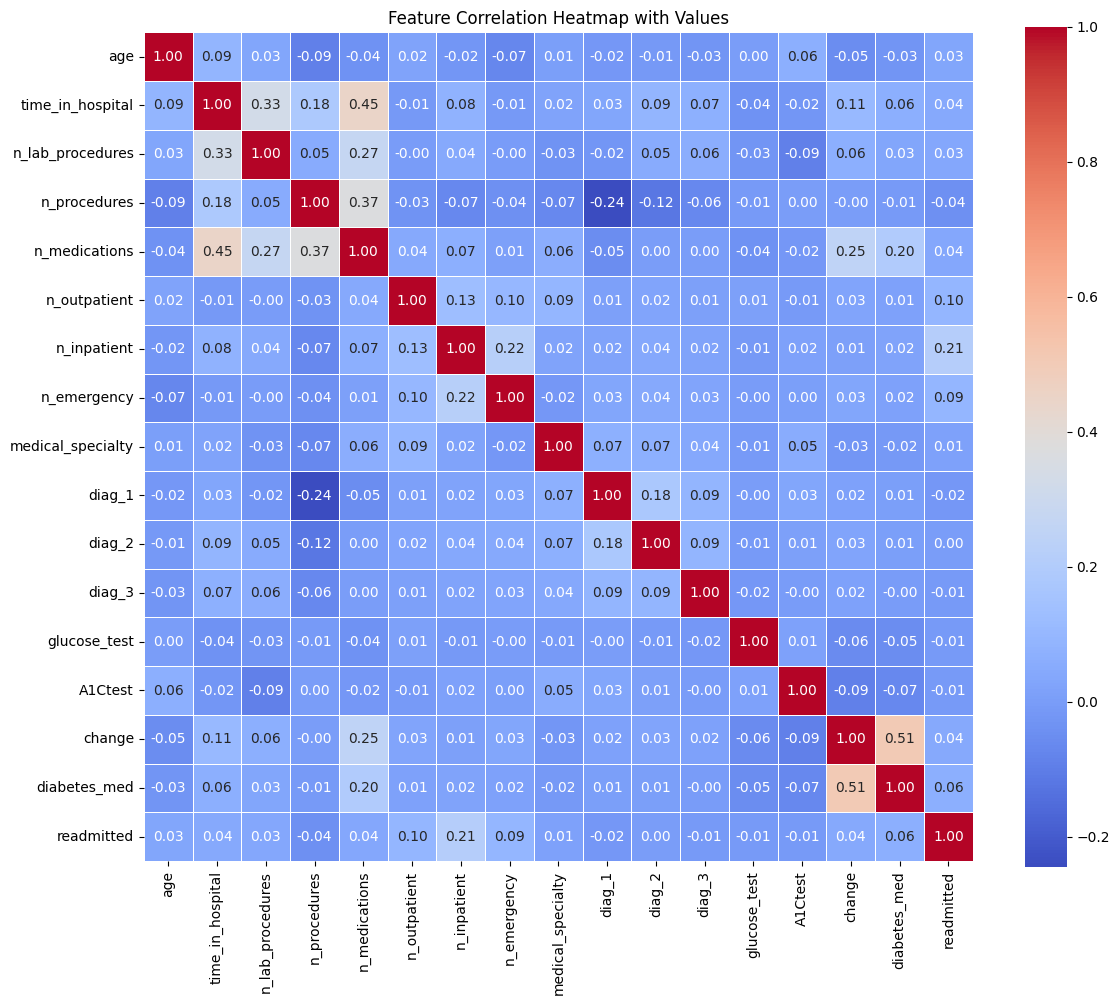

In [12]:
#Correlation Heatmap with Values
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, square=True)
plt.title("Feature Correlation Heatmap with Values")
plt.tight_layout()
plt.show()

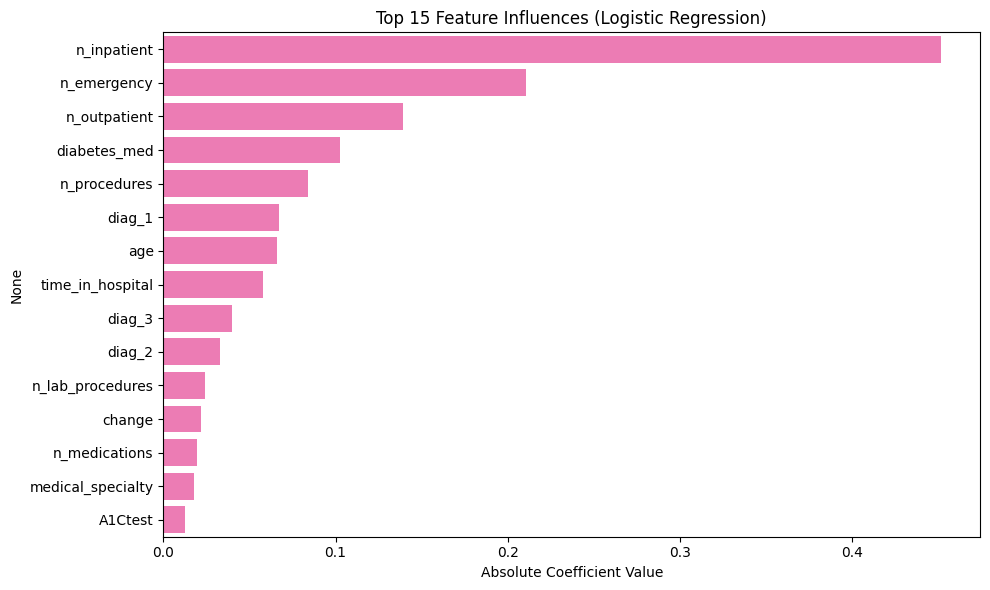

In [13]:
#Feature Influence - Logistic Regression
log_coefficients = pd.Series(log_model.coef_[0], index=X.columns)
log_coefficients = log_coefficients.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=log_coefficients.values[:15], y=log_coefficients.index[:15], color="hotpink")
plt.title("Top 15 Feature Influences (Logistic Regression)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

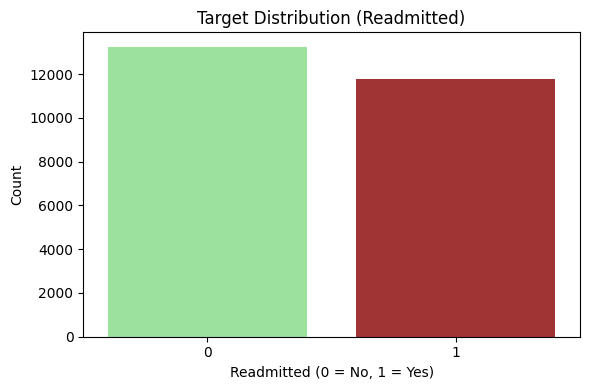

In [19]:
#Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y, hue=y, palette=["lightgreen", "firebrick"], legend=False)
plt.title("Target Distribution (Readmitted)")
plt.xlabel("Readmitted (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
